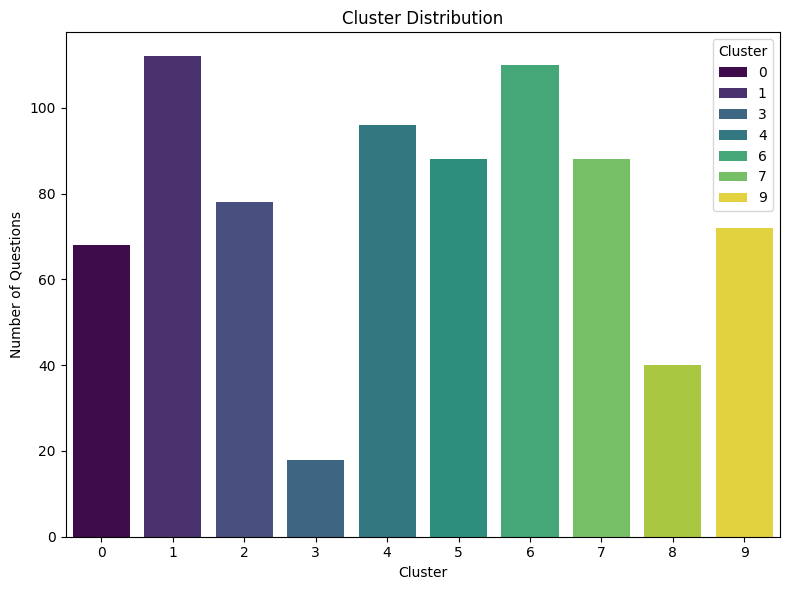

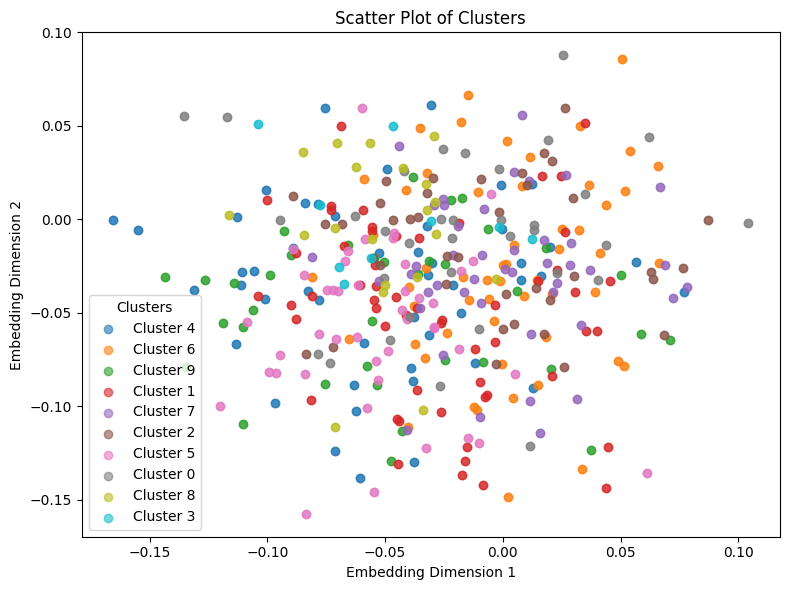

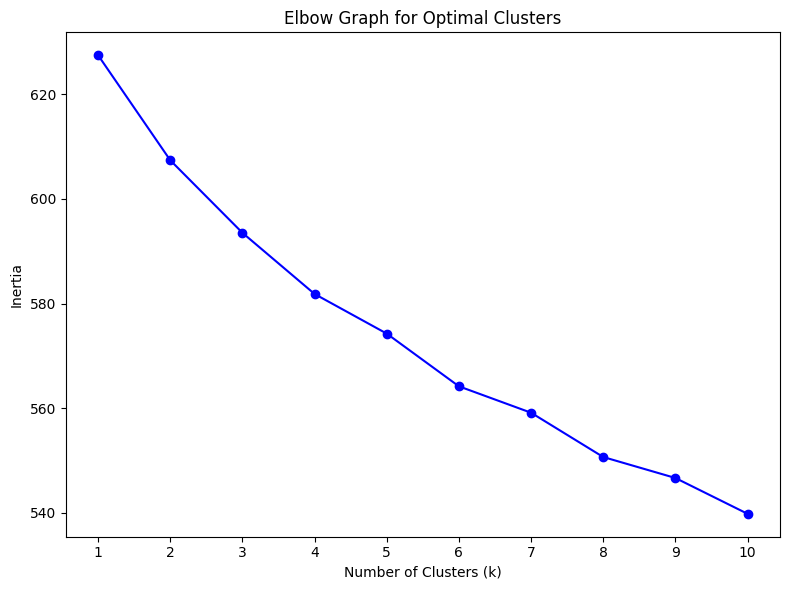

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import ast

# Database connection
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="yourDatabaseName",
    user="yourUsername",
    password="yourPassword"
)

def fetch_data(query):
    """Fetch data from the database using a query."""
    with conn.cursor() as cursor:
        cursor.execute(query)
        data = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        return pd.DataFrame(data, columns=columns)

# Load data from qa_table
qa_data = fetch_data("SELECT question_embedding, cluster_label FROM qa_table")

# Convert embeddings from string to numeric arrays
qa_data['question_embedding'] = qa_data['question_embedding'].apply(
    lambda x: np.array(ast.literal_eval(x))
)

# Extract embeddings and cluster labels
embeddings = np.array(qa_data['question_embedding'].tolist())
cluster_labels = qa_data['cluster_label']

# 1. Bar Graph for Clusters
plt.figure(figsize=(8, 6))
cluster_counts = cluster_labels.value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
sns.barplot(
    data=cluster_counts, x='Cluster', y='Count', palette='viridis', hue='Cluster', dodge=False
)
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Questions")
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

# 2. Scatter Plot for Clusters
plt.figure(figsize=(8, 6))
for cluster in cluster_labels.unique():
    cluster_points = embeddings[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)
plt.title("Scatter Plot of Clusters")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.legend(title="Clusters")
plt.tight_layout()
plt.show()

# 3. Elbow Graph for Optimal Clusters
plt.figure(figsize=(8, 6))
inertia = []
k_values = range(1, 11)  # Test k from 1 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o', color='blue')
plt.title("Elbow Graph for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.tight_layout()
plt.show()


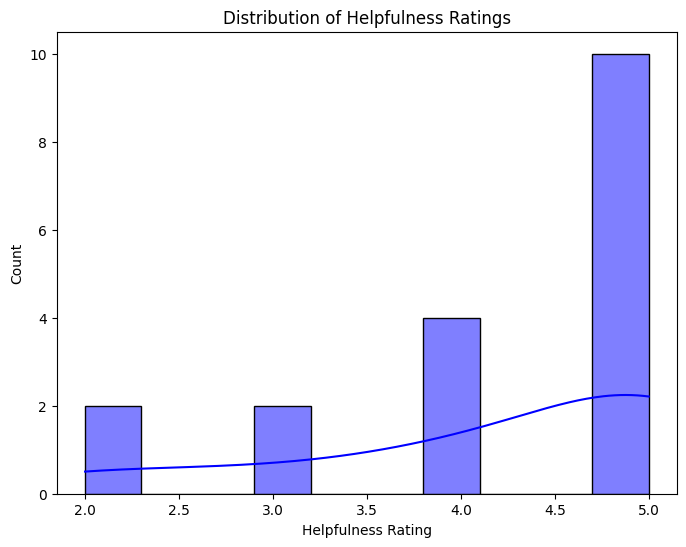

/tmp/ipykernel_32416/2592276865.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feedback_type_counts.index, y=feedback_type_counts.values, palette='viridis')


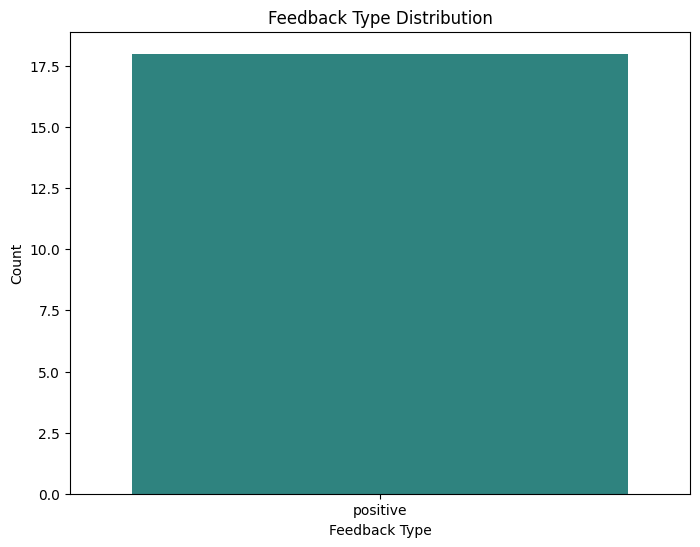

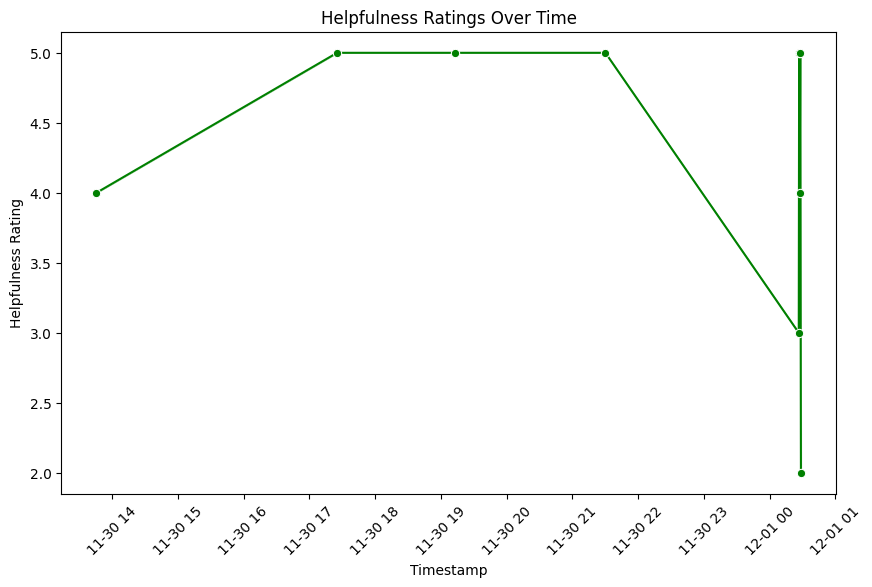

/tmp/ipykernel_32416/2592276865.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feedback_data, x='feedback_type', y='helpfulness_rating', palette='pastel')


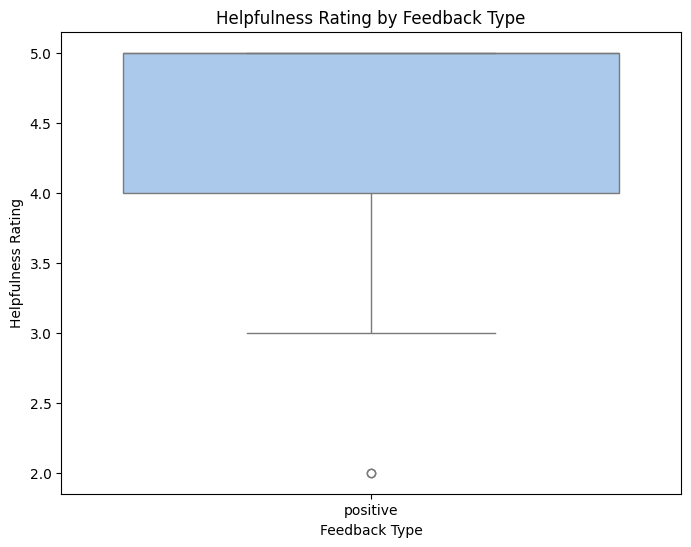

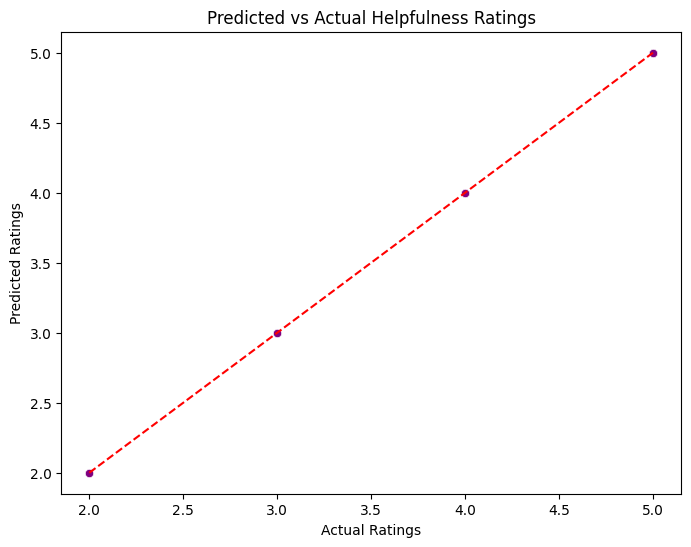

Mean Squared Error: 0.00
R-squared: 1.00


In [1]:
import psycopg2
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Database connection
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="yourDatabaseName",
    user="yourUsername",
    password="yourPassword"
)

def fetch_feedback_data():
    """Fetch feedback data from the database."""
    query = """
    SELECT q.question_embedding, f.helpfulness_rating, f.feedback_type, f.timestamp 
    FROM qa_table q 
    JOIN feedback_table f ON q.question = f.question;
    """
    with conn.cursor() as cursor:
        cursor.execute(query)
        data = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        return pd.DataFrame(data, columns=columns)

# Fetch feedback data
feedback_data = fetch_feedback_data()

# Preprocess the data
feedback_data['question_embedding'] = feedback_data['question_embedding'].apply(
    lambda x: np.array(ast.literal_eval(x))
)
feedback_data['timestamp'] = pd.to_datetime(feedback_data['timestamp'])

# 1. Histogram for Helpfulness Rating
plt.figure(figsize=(8, 6))
sns.histplot(data=feedback_data, x='helpfulness_rating', kde=True, bins=10, color='blue')
plt.title('Distribution of Helpfulness Ratings')
plt.xlabel('Helpfulness Rating')
plt.ylabel('Count')
plt.show()

# 2. Bar Chart for Feedback Type
plt.figure(figsize=(8, 6))
feedback_type_counts = feedback_data['feedback_type'].value_counts()
sns.barplot(x=feedback_type_counts.index, y=feedback_type_counts.values, palette='viridis')
plt.title('Feedback Type Distribution')
plt.xlabel('Feedback Type')
plt.ylabel('Count')
plt.show()

# 3. Line Plot for Rating Trends Over Time
plt.figure(figsize=(10, 6))
feedback_data.sort_values('timestamp', inplace=True)
sns.lineplot(data=feedback_data, x='timestamp', y='helpfulness_rating', marker='o', color='green')
plt.title('Helpfulness Ratings Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Helpfulness Rating')
plt.xticks(rotation=45)
plt.show()

# 4. Boxplot for Feedback Type and Rating
plt.figure(figsize=(8, 6))
sns.boxplot(data=feedback_data, x='feedback_type', y='helpfulness_rating', palette='pastel')
plt.title('Helpfulness Rating by Feedback Type')
plt.xlabel('Feedback Type')
plt.ylabel('Helpfulness Rating')
plt.show()

# 5. Linear Regression Patterns
# Combine embeddings with feedback type as features
encoder = LabelEncoder()
feedback_data['feedback_type_encoded'] = encoder.fit_transform(feedback_data['feedback_type'])
embeddings = np.array(feedback_data['question_embedding'].tolist())
features = np.column_stack((embeddings, feedback_data['feedback_type_encoded']))
ratings = feedback_data['helpfulness_rating']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train Linear Regression model
model = LinearRegression()
model.fit(features_scaled, ratings)
predicted_ratings = model.predict(features_scaled)

# Scatter plot for Predicted vs Actual Ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ratings, y=predicted_ratings, color='purple')
plt.plot([ratings.min(), ratings.max()], [ratings.min(), ratings.max()], '--r')  # Ideal line
plt.title('Predicted vs Actual Helpfulness Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

# Regression Metrics
mse = mean_squared_error(ratings, predicted_ratings)
r2 = r2_score(ratings, predicted_ratings)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
